In [1]:
# 데이터 플로팅 라이브러리
import matplotlib.pyplot as plt
# 숫자 처리 라이브러리
import numpy as np
# 딥러닝을 위한 파이토치 라이브러리
import torch
from torch import nn, optim
# 토치비전 라이브러리
import torchvision
from torchvision import datasets, transforms, models
# 이미지 처리 라이브러리 (PIL, pillow)
from PIL import Image
# 주피터 노트북에서 plot이 보이도록 설정
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(valid_size)을 정한다.
data_dir = './data'
valid_size = 0.2

In [3]:
# 위의 코드들을 묶어서 load_split_train_test() 함수를 만든다. (입력 : 데이터 디렉토리, 분할 비율) (출력 : 학습 데이터 로더, 테스트 데이터 로더)
t_transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.Resize(224),
            transforms.ToTensor()
])
def load_split_train_test(data_dir, valid_size) :  
    train_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    test_data = datasets.ImageFolder(data_dir, transform=t_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))

    np.random.shuffle(indices)
    split = int(np.floor(num_train * valid_size))
    train_idx, test_idx = indices[split:], indices[:split]
    from torch.utils.data.sampler import SubsetRandomSampler

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)

    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=16)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=16)

    return trainloader, testloader

In [4]:
# load_split_train_test() 함수를 이용하여 trainloader와 testloader를 만들고 확인한다.
trainloader, testloader = load_split_train_test(data_dir, valid_size)

print(trainloader.dataset.classes)
print(testloader.dataset.classes)

['Basalt', 'Highland']
['Basalt', 'Highland']


In [5]:
def get_random_images(num) :

    data = datasets.ImageFolder(data_dir, transform=t_transforms)
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]

    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, sampler=sampler, batch_size=num)
    # loader에서 데이터를 한 개씩 꺼내 주는 iterator를 생성한다.
    dataiter = iter(loader)
    images, labels = dataiter.next()

    return images, labels

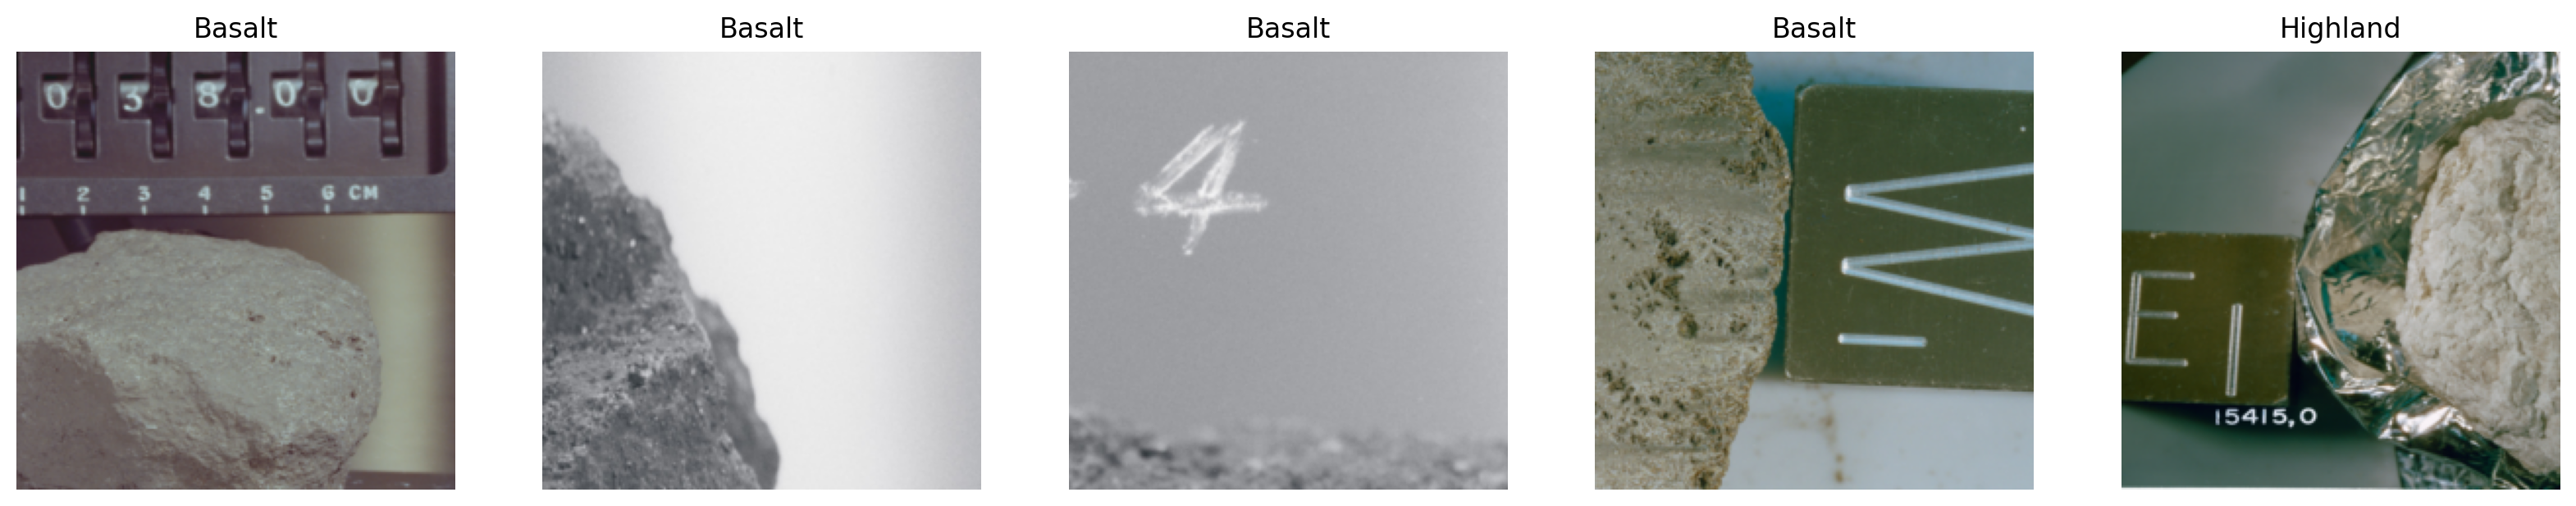

In [6]:
# 5개의 이미지와 레이블을 랜덤하게 가져온다.
images, labels = get_random_images(5)
# 픽셀 배열을 PIL 형식의 이미지로 변환하고 이미지 크기를 지정한다.
to_pil = transforms.ToPILImage()
fig = plt.figure(figsize=(20, 20))
# 학습 데이터의 class 리스트를 얻는다.
classes = trainloader.dataset.classes
# 이미지를 표시하기 위한 설정을 한다.
for ii in range(len(images)) :
    image = to_pil(images[ii])
    sub = fig.add_subplot(1, len(images), ii+1)
    index = labels[ii].item()
    sub.set_title(classes[index])
    plt.axis('off')
    plt.imshow(image)
# 주피터 노트북에 이미지를 표시한다.
plt.show()

In [7]:
# compute device를 정하고 확인한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [8]:
# resnet50 모델을 pretrained=True로 설정한다.
model = models.resnet50(pretrained=True)

/workspaces/el34_spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/workspaces/el34_spacerocks/.venv/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# 모든 신경망 구축 : 전이학습을 위해 모델의 가중치를 freeze 한다.
for param in model.parameters():
    # freeze model weights
    param.requires_grad = False
    
# 뉴런들을 연결하여 신경망을 생성한다.
model.fc = nn.Sequential(nn.Linear(2048, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512, 2),
                            nn.LogSoftmax(dim=1))
# q: explain the above code
# a: 2048개의 입력을 받아 512개의 출력을 내고, ReLU 함수를 거쳐 0.2의 확률로 Dropout을 적용한다.
# 512개의 입력을 받아 2개의 출력을 내고, LogSoftmax 함수를 거쳐 1차원으로 변환한다.
# 1차원으로 변환된 출력을 갖는 신경망을 생성한다.

# 손실함수를 Cross entropy loss 함수로 지정한다.
criterion = nn.NLLLoss()
# why
# optimizer를 Adam으로 지정한다.
# what is Adam
#
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
# 신경망을 compute device로 보낸다.
model.to(device)
# 종료 여부를 출력한다.
print('done!')

done!


In [11]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=512, out_features=2, bias=True)
  (4): LogSoftmax(dim=1)
)


In [12]:
# 에폭 및 출력 간격을 설정한다.
epochs = 10
print_every = 5
# 손실 변수들을 초기화 한다.
running_loss = 0
train_losses, test_losses = [], []
# 현재의 학습 단계를 표현하는 steps 변수를 0으로 초기화 한다.
steps = 0

In [13]:
# 설정한 회수만큼 학습 후 테스트 및 평가해 본다.
for epoch in range(epochs) :
    # 에폭을 count 한다.
    epoch += 1
    # trainloader로부터 모든 이미지와 레이블을 로드한다.
    for inputs, labels in trainloader:
        # 학습 단계를 count 하고 출력한다.
        steps += 1
        print('Training step ', steps)
        # 입력 데이터(이미지, 레이블)를 device로 보낸다.
        inputs, labels = inputs.to(device), labels.to(device)
        # 기존에 학습된 gradient 값을 초기화 한다.(이전에 학습한 값이 영향을 주지 않도록 함)
        optimizer.zero_grad()
        # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
        logps = model.forward(inputs)
        # 손실(loss) 값들을 계산한다.
        loss = criterion(logps, labels)
        # 손실값을 이용하여 gradient를 update한다.
        loss.backward()
        # gradient를 이용하여 설정된 optimizer로 파라미터를 update한다.
        optimizer.step()
        # 손실값을 누적/계산한다.
        running_loss += loss.item()
        # 학습 단계 5회마다 모델을 테스트/평가 한다.
        if steps % print_every == 0:
            # 손실과 정확도 변수를 초기화 한다.
            test_loss = 0
            accuracy = 0
            # 모델 평가 모드로 전환한다.
            model.eval()
            # 모델 평가 시 gradient를 계산하지 않도록 한다.
            with torch.no_grad():
                # testloader로부터 모든 이미지와 레이블을 로드한다.
                for inputs, labels in testloader:
                    # 입력 데이터(이미지, 레이블)를 device로 보낸다.
                    inputs, labels = inputs.to(device), labels.to(device)
                    # 입력 데이터로 순전파를 수행하고 로그 확률을 얻는다.
                    logps = model.forward(inputs)
                    # 손실(loss) 값들을 계산한다.
                    batch_loss = criterion(logps, labels)
                    # 손실값을 누적시킨다.
                    test_loss += batch_loss.item()
                    # 로그 확률로부터 진짜 확률값을 계산한다.
                    ps = torch.exp(logps)
                    # 가장 큰 확률값과 class를 얻는다. (topk : k번째로 큰 값)
                    top_p, top_class = ps.topk(1, dim=1)
                    # 레이블들을 top_class와 동일한 형태로 바꾼 후 같은 값들을 얻는다.
                    equals = top_class == labels.view(*top_class.shape)
                    # equals를 float 텐서로 바꾼 후 평균 정확도를 누적/계산한다.
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # 학습 손실값과 테스트 손실값을 추가한다.
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))
            # 학습 손실값, 테스트 손실값, 테스트 정확도를 출력한다.
            print("Epoch {}/{}: ".format(epoch, epochs),
                  "Train loss: {:.3f}.. ".format(running_loss/print_every),
                  "Test loss: {:.3f}.. ".format(test_loss/len(testloader)),
                  "Test accuracy: {:.3f}\n".format(accuracy/len(testloader))) 
            # running_loss 값을 초기화 한다.
            running_loss = 0
            # 모델 학습 모드로 전환한다.
            model.train()
            break

Training step  1
Training step  2
Training step  3
Training step  4
Training step  5
Epoch 1/10:  Train loss: 2.471..  Test loss: 0.694..  Test accuracy: 0.521

Training step  6
Training step  7
Training step  8
Training step  9
Training step  10
Epoch 2/10:  Train loss: 0.683..  Test loss: 1.851..  Test accuracy: 0.452

Training step  11
Training step  12
Training step  13
Training step  14
Training step  15
Epoch 3/10:  Train loss: 0.717..  Test loss: 0.591..  Test accuracy: 0.679

Training step  16
Training step  17
Training step  18
Training step  19
Training step  20
Epoch 4/10:  Train loss: 0.522..  Test loss: 0.332..  Test accuracy: 0.842

Training step  21
Training step  22
Training step  23
Training step  24
Training step  25
Epoch 5/10:  Train loss: 0.463..  Test loss: 0.281..  Test accuracy: 0.902

Training step  26
Training step  27
Training step  28
Training step  29
Training step  30
Epoch 6/10:  Train loss: 0.311..  Test loss: 0.210..  Test accuracy: 0.902

Training step

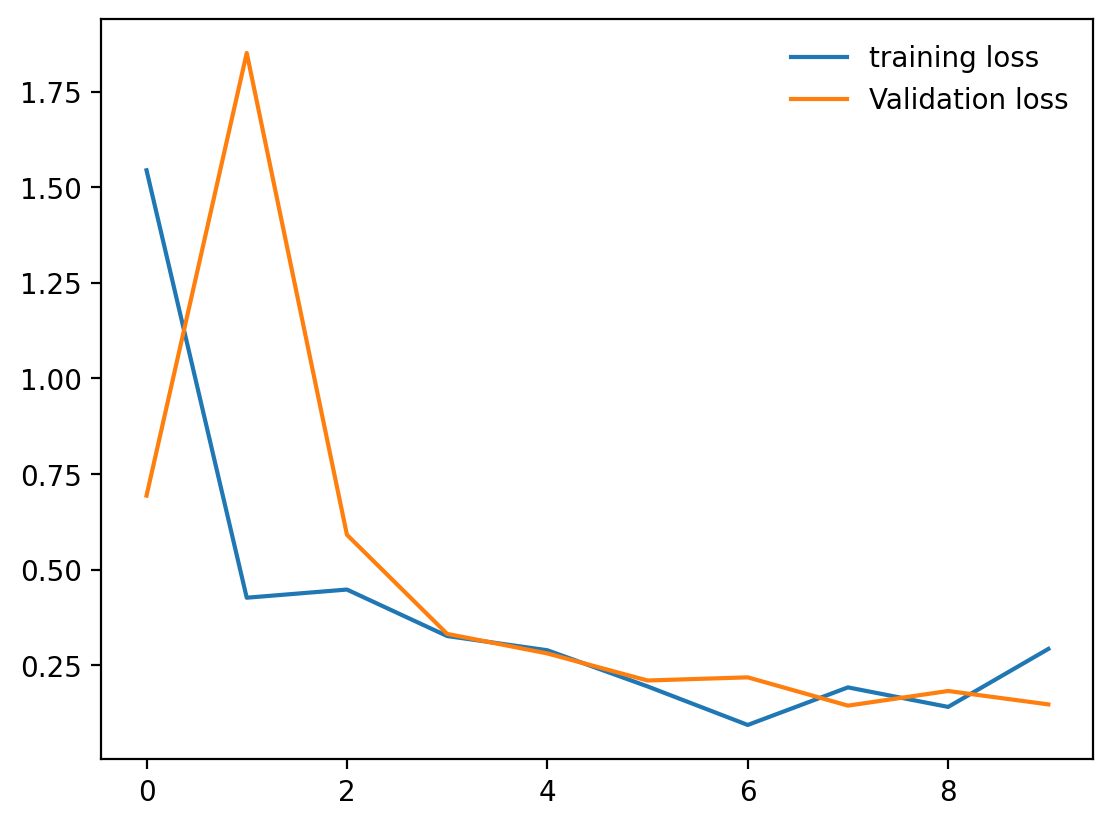

In [14]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

# in this graph, what is x-axis? y-axis?
# x-axis: epoch
# y-axis: loss

In [15]:
# 추후 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.
torch.save(model, 'moonrockmodel.pth')

# 추론해보기

In [16]:
# 저장한 모델을 불러온다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = torch.load('moonrockmodel.pth')

In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
def predict_image(image):
    image_tensor = t_transforms(image).float()
    input = image_tensor.unsqueeze_(0)
    input = input.to(device)
    output = model(input)
    index = output.data.numpy().argmax()

    return index

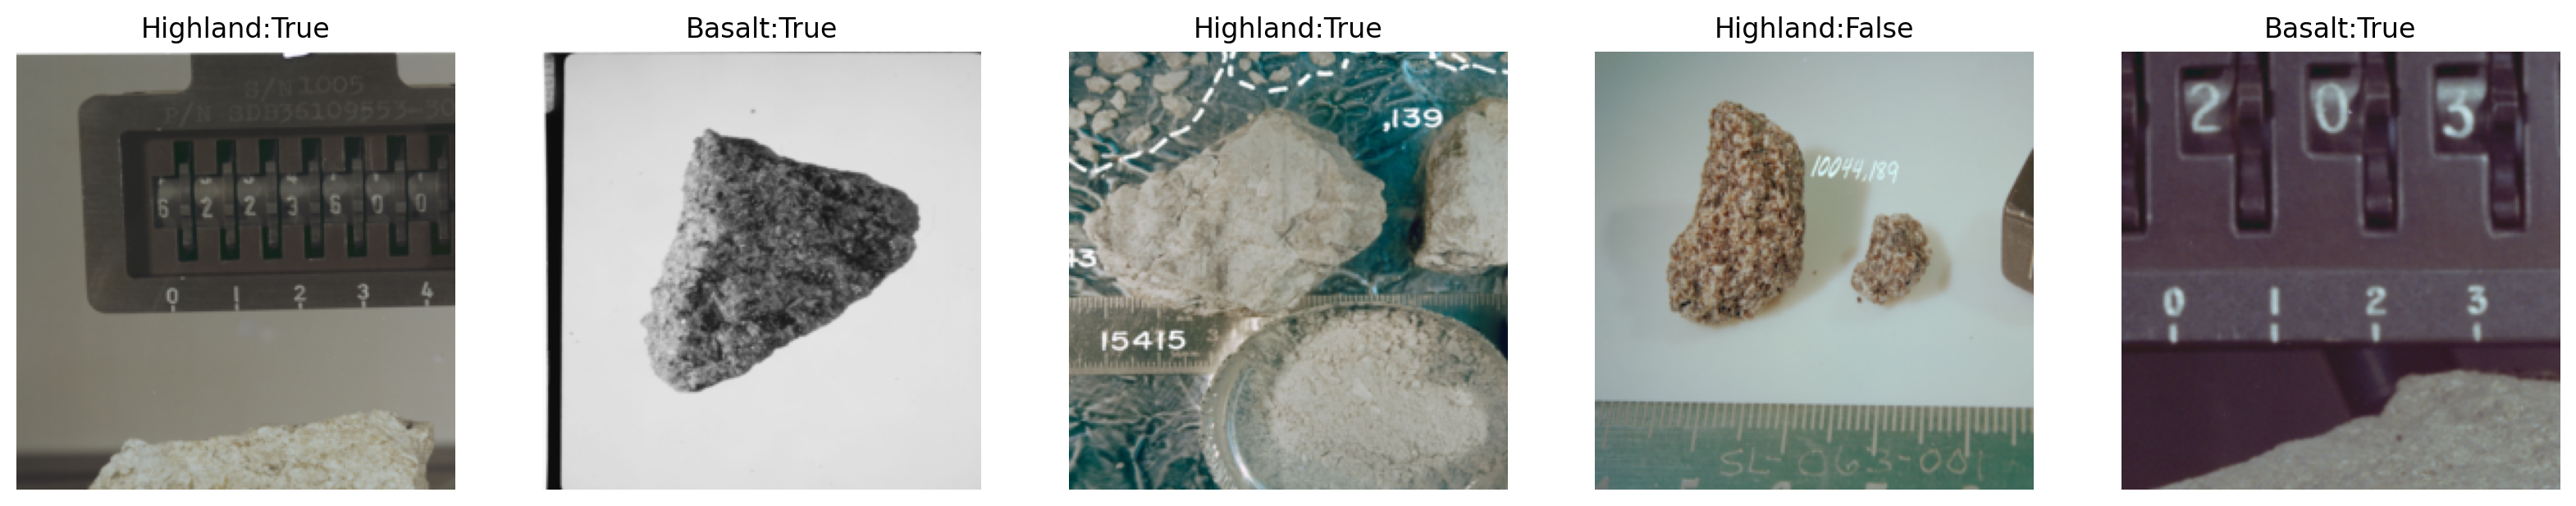

In [19]:
# 모델 평가 모드로 전환한다.
model.eval()
# 5개의 이미지를 랜덤하게 가져온 후 PIL 형식 변환, 표시할 이미지 크기를 설정한다.
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig = plt.figure(figsize=(20, 20))
# 데이터의 class 목록을 얻는다.
classes = trainloader.dataset.classes

# 5개의 이미지에 대해 loop를 수행한다.
for ii in range(len(images)):
    # 각 이미지에 대해 class를 예측한다.
    image = to_pil(images[ii])
    index = predict_image(image)
    # 이미지 아래에 class를 표시하도록 설정한다.
    sub = fig.add_subplot(1, len(images), ii+1)
    res = labels[ii].item() == index
    sub.set_title(classes[index] + ':' + str(res))
    plt.axis('off')
    plt.imshow(image)
# 레이블이 추가된 이미지를 보여준다.
plt.show()